In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, mutual_info_classif, RFECV
from sklearn.decomposition import PCA
import scipy.stats as st
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [5]:
train = pd.read_csv('/content/drive/MyDrive/MLP Project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/MLP Project/test.csv')
train = train[train.columns[1:]]
test = test[test.columns[1:]]
cols = test.columns

In [6]:
d = {'v_1': 'Binary',
'v_26': 'Binary',
'v_11': 'Binary',
'v_14': 'Binary',
'v_30': 'Binary', 'v_28': 'Binary', 'v_9': 'Binary', 'v_27': 'Binary',
'v_32': 'Nominal', 'v_4': 'Nominal',
'v_3': 'Nominal',
'v_20': 'Nominal',
'v_21': 'Nominal',
'v_18': 'Nominal',
'v_25': 'Nominal',
'v_12': 'Nominal', 'v_31': 'Ordinal',
'v_15': 'Ordinal',
'v_19': 'Ordinal',
'v_13': 'Ordinal',
'v_33': 'Ordinal',
'v_17': 'Ordinal',
'v_29': 'Ordinal',
'v_23': 'Ordinal',
'v_6': 'Ordinal', 'v_24': 'Ordinal', 'v_10': 'Ordinal', 'v_5': 'Ordinal',
'v_22': 'Ordinal', 'v_0': 'Ordinal',
'v_16': 'Ratio',
'v_2': 'Ratio',
'v_8': 'Ratio',
'v_7': 'Ratio' ,'v_34': 'Ratio', 'v_35': 'Ratio' ,'v_36': 'Ratio' ,'v_37': 'Ratio' ,'v_38': 'Ratio' ,'v_39': 'Ratio' ,'v_40': 'Ratio'}
types = list(set([value for key,value in d.items()]))
d = {k:[key for key,values in d.items() if values==k] for k in types}
numerical = d['Ratio']
nominal = d['Nominal']
ordinal = d['Ordinal']
binary = d['Binary']

In [7]:
X,Y = train.iloc[:,:-1], train.iloc[:,-1]

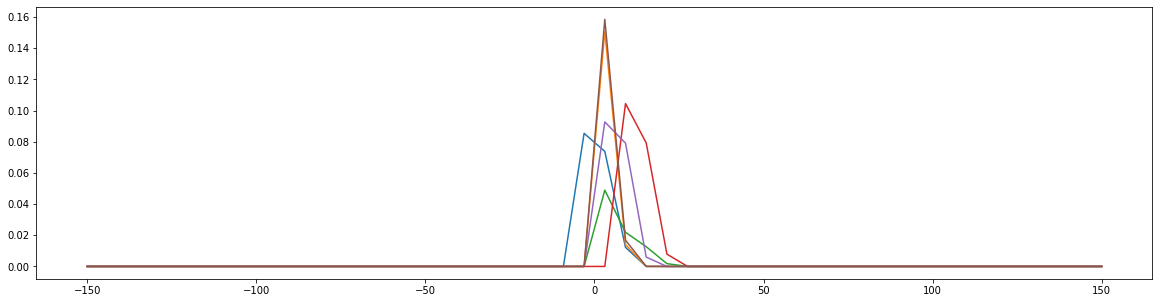

In [8]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()
normal = []
for i in range(len(numerical)):
  x = X[numerical[i]]
  eval_points = np.linspace(-150, 150)
  kernel = st.gaussian_kde(x)
  y = kernel.pdf(eval_points)
  if np.max(y) < 0.04:
    continue
  normal.append(numerical[i])
  plt.plot(eval_points, y)
minmax = list(set(numerical) - set(normal)) 

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [10]:
ct = ColumnTransformer([("normal", StandardScaler(), normal),
                        ("minmax", MinMaxScaler(), minmax),
                        ("nominal", OneHotEncoder(handle_unknown='ignore', sparse=False), nominal),
                        ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal),
                        ("binary", 'passthrough', binary)])
le = LabelEncoder()
X_train_transformed = ct.fit_transform(X_train)
Y_train_transformed = le.fit_transform(Y_train)
X_test_transformed = ct.transform(X_test)
Y_test_transformed = le.transform(Y_test)

In [11]:
def Testing(estimator, X_train, Y_train, X_test, Y_test):
  est = estimator.fit(X_train, Y_train)
  Y_pred = est.predict(X_test)
  return f1_score(Y_test, Y_pred, average='weighted')

In [12]:
def Validation(estimator, X, Y):
  v = []
  rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
  for train, test in rskf.split(X,Y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    Y_train, Y_test = Y.iloc[train], Y.iloc[test]
    X_train_transformed = ct.fit_transform(X_train)
    Y_train_transformed = le.fit_transform(Y_train)
    X_test_transformed = ct.transform(X_test)
    Y_test_transformed = le.transform(Y_test)
    estimator.fit(X_train_transformed, Y_train_transformed)
    v.append(f1_score(Y_test_transformed, estimator.predict(X_test_transformed),average='weighted'))
  return np.mean(np.asarray(v))

In [133]:
dtc = DecisionTreeClassifier(criterion='entropy', random_state=42, min_samples_split=218, splitter='best')
Validation(dtc, X, Y)

0.6854771290993068

In [132]:
params = {'criterion':['gini','entropy'], 'min_samples_split':np.linspace(0,400,401).astype(int), 'splitter':['best','random']}
rscv = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, random_state=42)
rscv.fit(X_train_transformed, Y_train_transformed)
rscv.best_params_

{'criterion': 'entropy', 'min_samples_split': 218, 'splitter': 'best'}